## Data Preprocessing

In [128]:
# Importign Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
from wordsegment import segment, load
from nltk.tokenize import TweetTokenizer
from textblob import TextBlob
load()
replace_by_space = re.compile('[/(){}\[\]\|@,;]')
replace_symbol = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
sns.set(style="darkgrid")

In [129]:
# Importinf Dataset
df = pd.read_csv('finalTrainingSetKaggle.csv')

In [123]:
# Dataset Head
df.head()

,Unnamed: 0,coordinates,created_at,hashtags,media,urls,favorite_count,TweetId,in_reply_to_screen_name,in_reply_to_status_id,...,Text_Only_Informative,Image_Only_Informative,Directed_Hate,Generalized_Hate,Sarcasm,Allegation,Justification,Refutation,Support,Oppose
0,0,NaN,Mon Oct 15 20:53:43 +0000 2018,ImWithHer MeToo Hypocrites,https://twitter.com/Mr_Nobull/status/105193919...,NaN,1,1051939199195045890,NaN,NaN,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,1,NaN,Fri Oct 12 18:14:29 +0000 2018,MeToo,https://twitter.com/Resist_N0W/status/10508119...,NaN,6,1050811961011838977,NaN,NaN,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,2,NaN,Wed Oct 10 07:51:58 +0000 2018,BrettKavanuagh auspol sharrimarkson metoo,https://twitter.com/PetefromHayNSW/status/1049...,NaN,124,1049930526314782720,NaN,NaN,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,NaN,Mon Oct 15 02:30:07 +0000 2018,MeToo,https://twitter.com/AmnestyNZ/status/105166146...,NaN,3,1051661466837901313,NaN,NaN,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4,NaN,Sun Oct 14 06:17:02 +0000 2018,HimToo MeToo,https://twitter.com/MichaelBCurran/status/1051...,https://buff.ly/2C9vFcS,0,1051356183402033152,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6799 entries, 0 to 6798
Data columns (total 45 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  6799 non-null   int64  
 1   coordinates                 5 non-null      object 
 2   created_at                  6799 non-null   object 
 3   hashtags                    6799 non-null   object 
 4   media                       6790 non-null   object 
 5   urls                        3277 non-null   object 
 6   favorite_count              6799 non-null   int64  
 7   TweetId                     6799 non-null   int64  
 8   in_reply_to_screen_name     745 non-null    object 
 9   in_reply_to_status_id       592 non-null    float64
 10  in_reply_to_user_id         745 non-null    float64
 11  lang                        6799 non-null   object 
 12  place                       415 non-null    object 
 13  possibly_sensitive          6799 

## Preprocessing Hashtag

In [13]:
# Hashtag 
tknzr = TweetTokenizer(reduce_len=True, preserve_case=False, strip_handles=False)
def hashtag_pre(text):
    if(text == ' '):
        return text
    text = str(text)
    text = text.split(' ')
    t =' '
    for i in text:
        if(len(i) != 0):
            t+= (" "+(' '.join(segment(i))))
    tokens = tknzr.tokenize(t.lower())
    return " ".join(tokens)

## Preprocessing Emoji

In [ ]:
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
def convert_emojis(text):
    for emot in UNICODE_EMO:
        text = text.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()))
    return text

## Preprocessing text

In [124]:
def text_preprocess(text):
    FLAGS = re.MULTILINE | re.DOTALL
    eyes = r"[8:=;]"
    nose = r"['`\-]?"

    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)
    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
    text = re_sub(r"/"," / ")
    text = re_sub(r"@\w+", "<user>")
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<smile>")
    text = re_sub(r"{}{}p+".format(eyes, nose), "<lolface>")
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<sadface>")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "<neutralface>")
    text = re_sub(r"<3","<heart>")
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<number>")
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")
    text = re_sub(r"#\S+", lambda hashtag: " ".join(segment(hashtag.group()[1:]))) # segment hastags
    text = " ".join([word for word in str(text).split() if word not in STOPWORDS])

    tokens = tknzr.tokenize(text.lower())
    return " ".join(tokens)

In [ ]:
# Preprocessing Hashtag
df['hashtags'] = df['hashtags'].apply(hashtag_pre)

# Preprocessing text
df['text'] = df['text'].apply(convert_emojis)
df['text'] = df['text'].apply(text_preprocess)
df['text'] = df['text'].apply(hashtag_pre)

# Spelling correction using TextBlob
df['hashtags'] = df['hashtags'].apply(lambda x: str(TextBlob(x).correct())) 
df['text'] = df['text'].apply(lambda x: str(TextBlob(x).correct())) 

### Creating new dataset with precessedText as combined preprocessed data of hashtag and text.

In [ ]:
new_df = pd.DataFrame({'TweetId':df.TweetId,'processedText': df.hashtags + df.text, 'Text_Only_Informative':d.Text_Only_Informative, 'Image_Only_Informative':d.Image_Only_Informative, 'Directed_Hate':d.Directed_Hate,'Generalized_Hate':d.Generalized_Hate,'Sarcasm':d.Sarcasm,'Allegation':d.Allegation,'Justification':d.Justification,'Refutation':d.Refutation,'Support':d.Support,'Oppose':d.Oppose})

In [ ]:
new_df.to_csv('new_df.csv', index = False)

# Now 2nd approach: Extracting Title and description for give url.

In [126]:
# function to extract Title and description of the given URL.
def url_data(link):
    url = link
    l = url.split('/')
    link_data = ' '
    tw = False
    try:
        for i in l:
            if(i == 'twitter.com'):
                tw = True
                t_id = int( l[len(l)-1] )
                tweet = twitter.show_status(id = t_id )
                link_data+=tweet['text']
                if(len(tweet['entities']['hashtags']) != 0):
                    for j in tweet['entities']['hashtags']:
                        link_data = j['text']+' '+link_data
        if(tw == False):
            headers ={"User-Agent":"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.106 Safari/537.36"}
            with requests.Session() as s:
                r = s.get(url, headers=headers)
                soup = BeautifulSoup(r.text, "lxml")
                link_data+= (soup.title.string+ ' ')
                link_data+= soup.find("meta",  property="og:description")["content"]
                
        return link_data
    except:
        print("No Data found for url -- " , link)
        return link_data

 Applying `url_data` function to url column of the dataset. And saving concatenate version of title and description. 

In [ ]:
df['urls'] = df['urls'].apply(url_data)

Now cleaning the uls data.

In [ ]:
df['urls'] = df['urls'].apply(hashtag_pre)
df['urls'] = df['urls'].apply(convert_emojis)
df['urls'] = df['urls'].apply(text_preprocess)
df['urls'] = df['urls'].apply(lambda x: str(TextBlob(x).correct())) 

### Creating new dataset with precessedText as combined preprocessed data of hashtag, text, and urls.

In [ ]:
url_df = pd.DataFrame({'TweetId':df.TweetId,'processedText': df.hashtags + df.text + df.urls, 'Text_Only_Informative':d.Text_Only_Informative, 'Image_Only_Informative':d.Image_Only_Informative, 'Directed_Hate':d.Directed_Hate,'Generalized_Hate':d.Generalized_Hate,'Sarcasm':d.Sarcasm,'Allegation':d.Allegation,'Justification':d.Justification,'Refutation':d.Refutation,'Support':d.Support,'Oppose':d.Oppose})

### Converting final Dataframe to csv file.

In [ ]:
url_df.to_csv('final_df.csv', index = False)

# EDA

### All null values for each column in dataset. And ploting heatmap for that.

Unnamed: 0                       0
coordinates                   6794
created_at                       0
hashtags                         0
media                            9
urls                          3522
favorite_count                   0
TweetId                          0
in_reply_to_screen_name       6054
in_reply_to_status_id         6207
in_reply_to_user_id           6054
lang                             0
place                         6384
possibly_sensitive               0
retweet_count                    0
retweet_id                    6799
retweet_screen_name           6799
source                           0
text                             0
tweet_url                        0
user_created_at                  0
user_screen_name                 0
user_default_profile_image       0
user_description               244
user_favourites_count            0
user_followers_count             0
user_friends_count               0
user_listed_count                0
user_location       

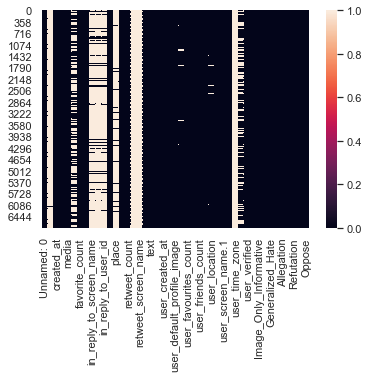

In [134]:
print(df.isnull().sum())
sns.heatmap(df.isnull())

### Class distribution

In [130]:
# All Class names
class_names = ['Text_Only_Informative', 'Image_Only_Informative', 'Directed_Hate', 'Generalized_Hate', 'Sarcasm', 'Allegation', 'Justification', 'Refutation', 'Support', 'Oppose']

In [131]:
# Collecting total count of each class.
count = {}
for a in class_names:
    count[a] = df[a].sum()

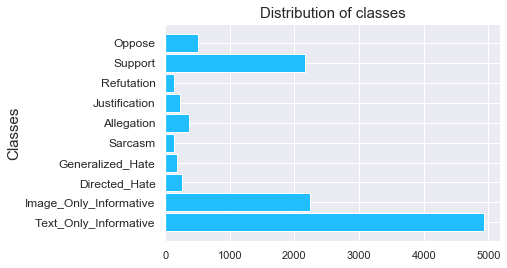

In [132]:
plt.figure()
plt.barh(np.arange(len(class_names)), count.values(), color='#20beff', height=0.9)
plt.yticks(np.arange(len(count)),list(count.keys()), fontsize=12)
plt.title("Distribution of classes", fontsize=15)
plt.ylabel("Classes", fontsize=15)
#plt.savefig('classes.png')
plt.show()

# WordCloud  
Word Cloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance.
Here we are generating WordCloud for text data.

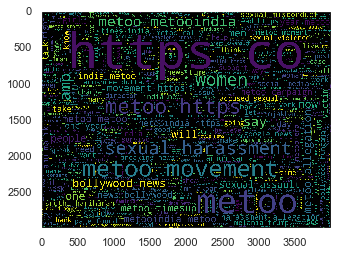

In [110]:
from wordcloud import WordCloud, STOPWORDS 
idx =0
jdx=0
a = df['text'] + df['hashtags'] + df['urls'] 
comment_words = ''
for val in a: 
    val = str(val) 
    tokens = val.split() 
    for i in range(len(tokens)): 
        if(tokens[i] != 'https' or tokens[i] != 'CO'):
            tokens[i] = tokens[i].lower() 
    comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 4000, height = 3000, max_words=1000).generate(str(comment_words))
plt.grid(False)
plt.imshow(wordcloud)       